In [14]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [15]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


In [16]:
standardizer = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [17]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
noise_dim = 100
BATHC_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 200

In [19]:
class DCDisc(nn.Module):
    def __init__(self):
        super(DCDisc, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.model(x)
        x = x.view((-1,1))
        return x



In [20]:
class DCGen(nn.Module):
    def __init__(self):
        super(DCGen, self).__init__()
        self.dconv = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    

    def forward(self, x):
        x = x.view((-1, noise_dim, 1, 1))
        x = self.dconv(x)
        return x

In [21]:
def get_z(batch_size=BATHC_SIZE):
    return cuda.FloatTensor(torch.randn(batch_size, noise_dim, device=device))

In [22]:
train_data = datasets.MNIST(root='./mnist/', train=True, download=True, transform=standardizer)
test_data = datasets.MNIST(root='./mnist/', train=False, download=True, transform=standardizer)
total_train = torch.utils.data.ConcatDataset([train_data, test_data])

train_dataloader = torch.utils.data.DataLoader(dataset=total_train, batch_size=BATHC_SIZE, shuffle=True)

In [23]:
def train(G, D, optim_G, optim_D, train_loader):
    G.train()
    D.train()
    criterion = nn.BCELoss()
    for epoch in range(EPOCHS):
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            optim_D.zero_grad()
            p_real = D(imgs)
            p_fake = D(G(get_z(batch_size=imgs.shape[0])))

            loss_d_real = criterion(p_real, torch.ones_like(p_real).to(device))  #-1.0 * torch.log(p_real)
            loss_d_fake = criterion(p_fake, torch.zeros_like(p_fake).to(device))  #-1.0 * torch.log(1. - p_fake)

            loss_d = (loss_d_real + loss_d_fake)  #.mean()

            loss_d.backward()
            optim_D.step()

            optim_G.zero_grad()

            #p_fake = -1.0 * torch.log(G(get_z(batch_size=imgs.shape[0])))

            loss_g =  criterion(D(G(get_z(batch_size=imgs.shape[0]))), torch.ones_like(p_fake).to(device)) #-1.0 * torch.log(p_fake).mean()

            loss_g.backward()

            optim_G.step()
        
        if epoch % 10 == 0:
            print(f'[{epoch}/{EPOCHS}] Loss_G : {loss_g:.5f}, Loss_D : {loss_d:.5f}')
            imshow_grid(G(get_z(batch_size=16)))



In [24]:
def init_params(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)



In [25]:
gen = DCGen().to(device)
disc = DCDisc().to(device)
init_params(gen)
init_params(disc)
optim_G = optim.Adam(lr=LEARNING_RATE, params=gen.parameters())
optim_D = optim.Adam(lr=LEARNING_RATE, params=disc.parameters())

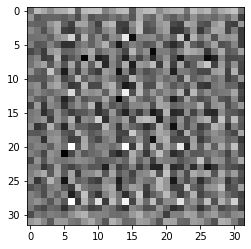

torch.Size([10, 32, 32])

In [26]:
z = get_z(batch_size=10)
img_fake = gen(z).view((-1, 32, 32))
imshow(img_fake[0].cpu().detach())
img_fake.shape

[0/200] Loss_G : 8.30697, Loss_D : 0.00790


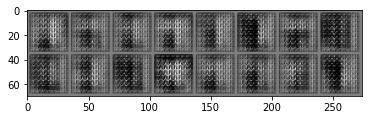

[10/200] Loss_G : 5.20988, Loss_D : 0.05171


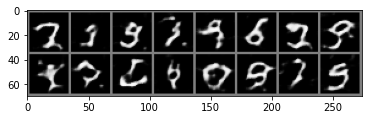

[20/200] Loss_G : 6.30124, Loss_D : 0.14509


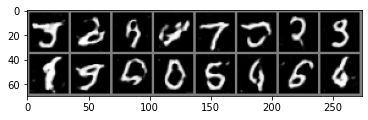

[30/200] Loss_G : 8.84891, Loss_D : 0.03505


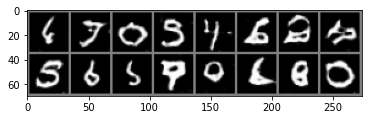

[40/200] Loss_G : 5.58813, Loss_D : 0.04398


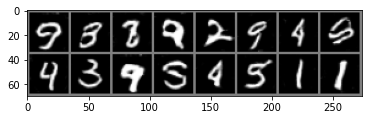

[50/200] Loss_G : 6.34997, Loss_D : 0.04627


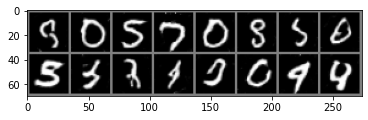

[60/200] Loss_G : 6.17517, Loss_D : 0.01204


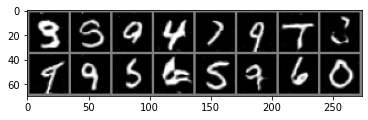

[70/200] Loss_G : 5.04333, Loss_D : 0.02229


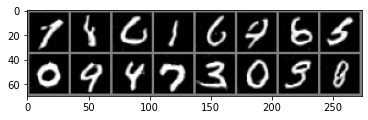

[80/200] Loss_G : 5.94425, Loss_D : 0.01966


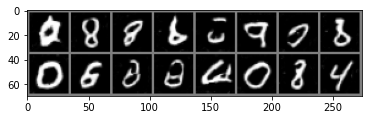

[90/200] Loss_G : 1.75309, Loss_D : 0.49726


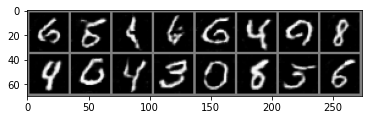

[100/200] Loss_G : 1.51500, Loss_D : 0.27756


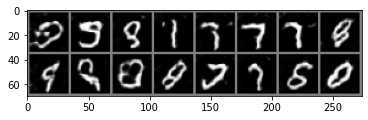

[110/200] Loss_G : 4.17275, Loss_D : 0.09062


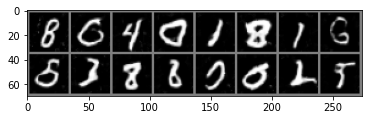

[120/200] Loss_G : 0.00000, Loss_D : 100.00001


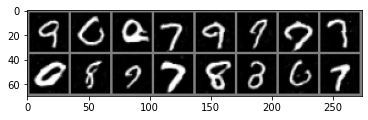

[130/200] Loss_G : 0.00000, Loss_D : 100.00001


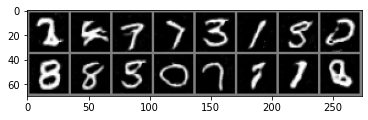

[140/200] Loss_G : 0.00000, Loss_D : 100.00001


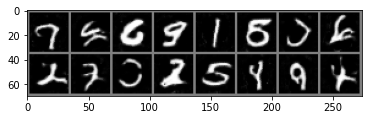

[150/200] Loss_G : 0.00000, Loss_D : 100.00001


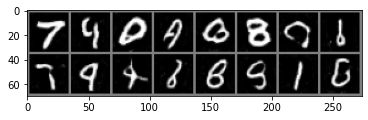

[160/200] Loss_G : 0.00000, Loss_D : 100.00001


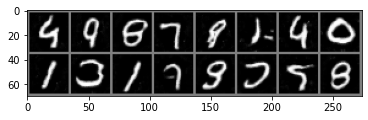

[170/200] Loss_G : 0.00000, Loss_D : 100.00001


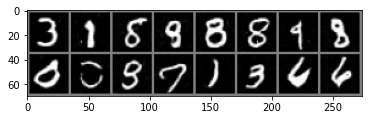

[180/200] Loss_G : 0.00000, Loss_D : 100.00001


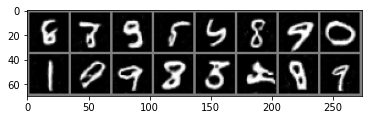

[190/200] Loss_G : 0.00000, Loss_D : 100.00001


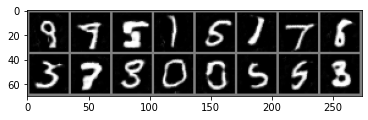

In [27]:
train(gen, disc, optim_G, optim_D, train_dataloader)

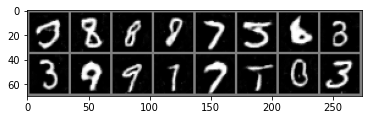

In [28]:
z = get_z(batch_size=16)
imgs = gen(z)
imshow_grid(imgs.cpu().detach())

In [ ]:
torch.save(gen, './model/dcgenerator.pth')
torch.save(disc, './model/dcdiscrminator.pth')